In [1]:
exclude_pids = [
    "65e5e9c2c0bfcbcbe835ec4d",
    "60fd64fd34ee5940500d499f",
    "61679f24fb77ff4978222991",
    "63fceba525d21052bc1ee390",
    "6526246367b37eef371ba914",
    "65798ffea5411209c86f31df",
    "65c630cc3824e0cf64dd2f7a",
    "615251a465f058e211cfbbb8",
    "5b197b8088ee7400012ae154",
    "5bad4db8b712f30001b87990",
    "5e6fd38fe95be7071b5196bf",
    "5fd79aba1833640f79ffd07d",
    "603421c858a3bd213d7c24b2",
    "604011377e5b121dc3267a3e",
    "60933bb6e47eb28c880b93d9",
    "613ad21e63b6c74708c223a9",
    "63bed6e176fba857a47fbaff",
    "63d54c4128bf8c671033ade4",
    "652da7c42cac6d10ff9de007",
    "65a6900704afb0a6f2f893d4",
    "65ba2af02a6a7f08d9e2b6c2",
    "660b812f113edc37de1df2b3",
    "6633381060353bc96809fc95",
    "660c87ac0012e87d84862040",
    "6414be45ec452483d7579868",
    "654e5bcb8cb6aeb8ca9b33a0",
    "661939712ce7ac67b60ab773",
    "5e2380c152e7a66358a276c5",
    "65086209d6edf5f2cf5f05d4",
    "6138df3f784ed068ae002cb3",
    "5d5035c5d87393001af70561",
    "614fe09fec9ce4a2a415476d",
    "5dd6dadf9c84d86703aa8615",
    "64528f4d51f889c0c30573af",
    "57ab3f8321e5a50001562cd3",
    "5ff39ec71d6cb49c6c906727",
    "603000ac19eaccdcf8b92e62",
    "61215755cea9b916eef0a38b"
]

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

df = pd.read_csv('raw_experiments.csv', index_col=0)
print(len(df))
df = df[~df.pid.isin(exclude_pids)]
print(len(df))
for col in df.columns:
    print(col)

1691
1542
experiment
human_role
map
pid
game_time
is_time_success
user number of utterances
user mean utterance length
user total number of tokens
user number of eng utterances
user number of es utterances
user number of mix utterances
user number of none utterances
user number of inter-sentential cs
user number of utterances with some ins switch
user number of total ins switches
user number of cong_masc switches
user number of cong_fem switches
user number of incong_masc switches
user number of incong_fem switches
user number of NP switches
user number of amb_masc switches
user number of amb_fem switches
user number of masc det switches
user number of fem det switches
user % entrainment - all dialog
user % entrainment - on bot inter-sentential cs
bot number of utterances
bot mean utterance length
bot total number of tokens
bot number of eng utterances
bot number of es utterances
bot number of mix utterances
bot number of none utterances
bot number of inter-sentential cs
bot number of 

In [8]:
alt_experiments = ['Alternation Baseline', 'Alternation Random CS', 'Alternation Short-context CS',
                   'Alternation Alignment CS', 'Alternation Adversarial CS']
ins_experiments = ['Insertional Spanish Baseline', 'Insertional Spanish Congruent','Insertional Spanish Masculine InCongruent',
                   'Insertional Spanish Feminine InCongruent']
global_exp_ =  'alt' #'ins' # 'alt'


experiments = ins_experiments if global_exp_ == 'ins' else alt_experiments
role = 'all' #'all' #'instructor' #'navigator'


In [9]:
def get_experiment_df(exp: list[str]):
    new_df = df[df['experiment'].isin(exp)]
    if role == 'all':
        return new_df
    return new_df[new_df['human_role'] == role]

def fix_lng_cols(text):
    if type(text) == float:
        return 'NONE'
    text = text.strip().lower()
    if text in ['english', 'enlgish', 'englis', 'eng']:
        return 'ENG'
    if text in ['spanish']:
        return 'ES'
    if 'eng' in text and 'spa' in text:
        return 'BOTH'
    if text in ['portuguese']:
        return 'NONE'
    else:
        return 'NONE'

def remove_rename_columns(df, remove=True):
    questions_rename = {'How much did you enjoy the task?' : 'Q_enjoy',
                        "How successful do you think you were at completing the task?" : 'Q_successful',
                        "How likely would you be to mix languages in the following contexts? Interacting with friends": "Q_mix_friends",
                        'Do you enjoy mixing languages in conversation?': "Q_enjoy_mix",
                        "How natural was your conversational partner’s language switching?": "Q_natural",
                        "On a day-to-day basis, how likely are you to have a conversation using both English and Spanish?": "Q_mix_often"
                       }
    if remove:
        remove_cols = ['human_role', 'experiment', 'map', 'pid']
        all_cols = list(df.columns)
        remove_cols.extend(list(filter(lambda x: 'bot_' in x, all_cols)))
        df = df.drop(remove_cols, axis=1)
    
    df = df.rename(columns=questions_rename, errors="raise")
    
    df["English %"] = df["user number of eng utterances"] / df["user number of utterances"] *100 
    df["None %"] = df["user number of none utterances"] / df["user number of utterances"] *100 
    df["Spanish %"] = df["user number of es utterances"] / df["user number of utterances"]  *100
    df["Mix %"] = df["user number of mix utterances"] / df["user number of utterances"]  *100
    
    df["Inter-Sentential CS %"] = df["user number of inter-sentential cs"] / (df["user number of utterances"] - 1)  *100

    df['% entrainment - on bot inter-sentential cs'] = df['user % entrainment - on bot inter-sentential cs'] * 100
    df['% entrainment - all dialog'] = df['user % entrainment - all dialog'] * 100

    # remove custom na
    if global_exp_ == 'ins':
        df = df.drop(df.loc[df['Q_natural'] == 'na'].index)
        df = df.drop(df.loc[df['Q_mix_often'] == 'na'].index)

    df = df.drop(df.loc[df['Q_mix_friends'] == 'na'].index)
    df = df.drop(df.loc[df['Q_enjoy_mix'] == 'na'].index)


    df['Q_mix_friends'] = df['Q_mix_friends'].astype(int)
    df['Q_enjoy_mix'] = df['Q_enjoy_mix'].astype(int)

    if global_exp_ == 'ins':
        df['Q_natural'] = df['Q_natural'].astype(int)
        df['Q_mix_often'] = df['Q_mix_often'].astype(int)


    
    df['lng_1'] = df['Enter your native language, or the language you are providing answers for, here:'].apply(fix_lng_cols)
    df['lng_2'] = df['Enter your most proficient second language here:'].apply(fix_lng_cols)
        
    
    return df


In [10]:
def plot_corr_matt(df, title):
    f = plt.figure(figsize=(15, 15))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
    plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title(f'{title} - Correlation Matrix', fontsize=16)

    
def plot_2d_scatter(df, title, x, y, color, size):
    print(df.shape)
    fig = px.scatter(df, x=x, y=y, color=color, size=size, title=title)
    fig.show()

In [11]:
df_copy = get_experiment_df(experiments)
df_copy = remove_rename_columns(df_copy, False)
print(df_copy.shape)

(846, 128)


In [ ]:
# df_corr = get_experiment_df(experiments)
# df_corr = remove_rename_columns(df_corr, True)
# df_corr.corr()

(846, 128)


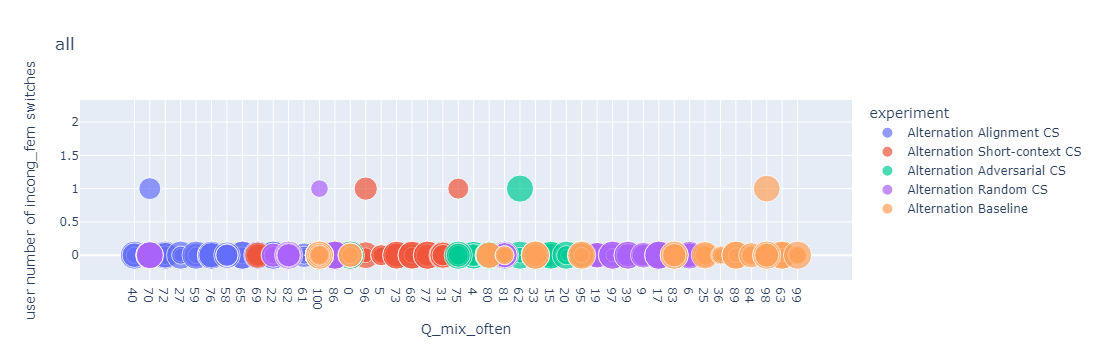

(846, 128)


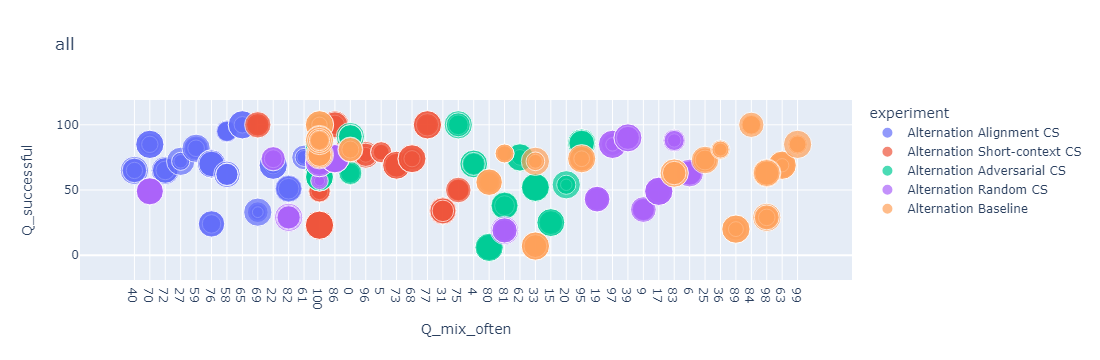

(846, 128)


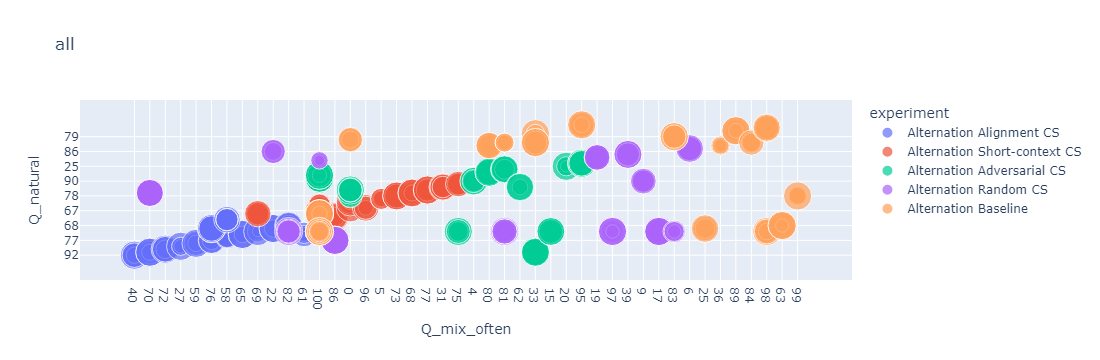

(846, 128)


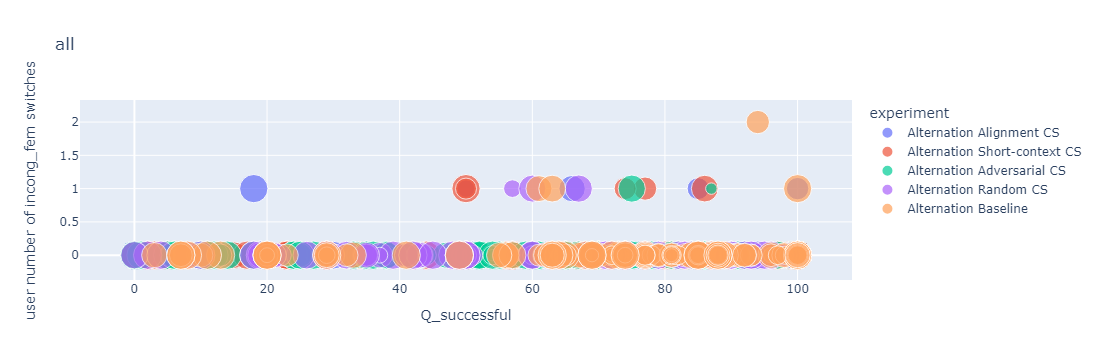

(846, 128)


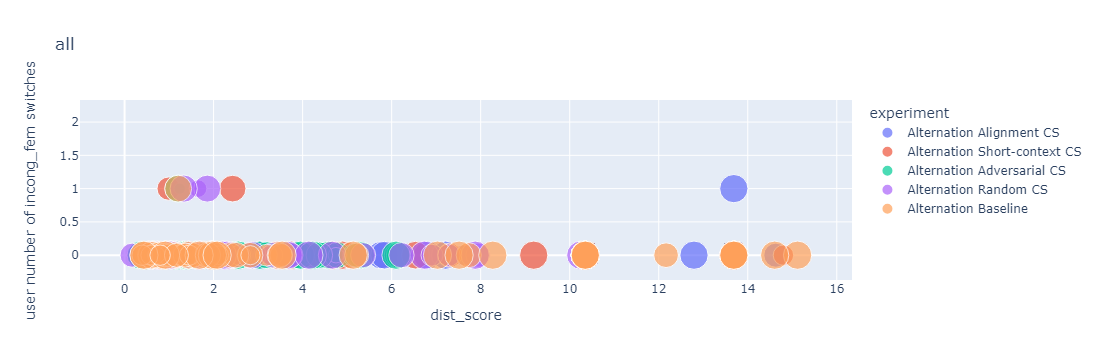

(846, 128)


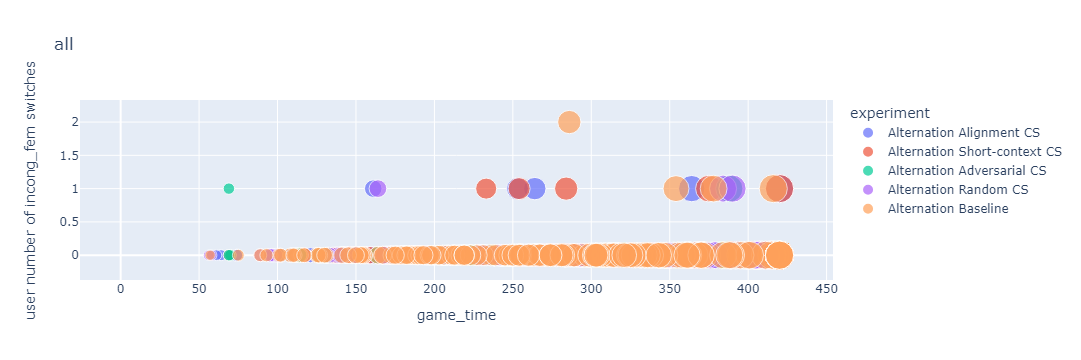

(846, 128)


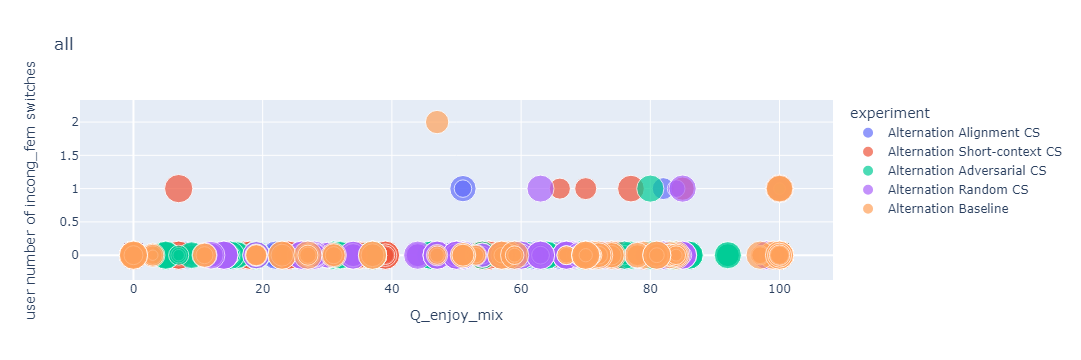

(846, 128)


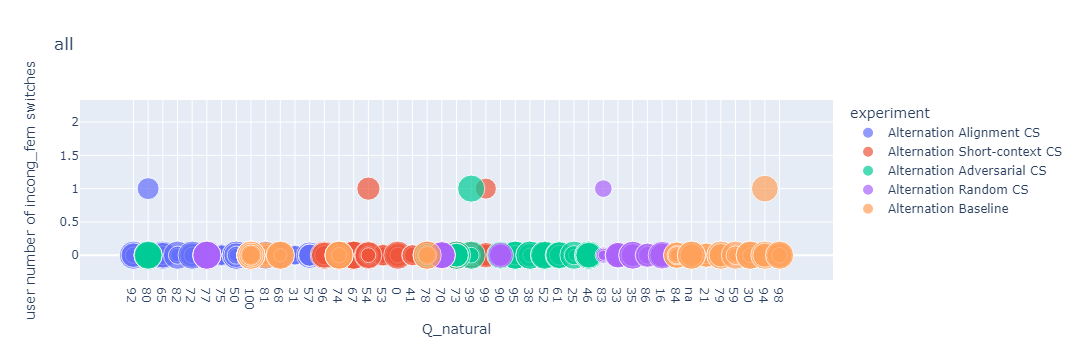

(846, 128)


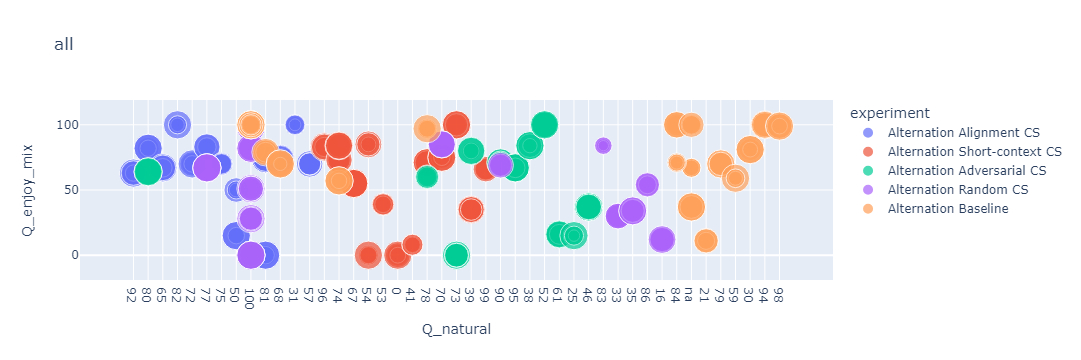

In [12]:


# y = 'user number of total ins switches'
# y = "user number of utterances with some ins switch"
y = 'user number of incong_fem switches'

plot_2d_scatter(df=df_copy,
        x="Q_mix_often",
        y=y,
        color='experiment',
        size='game_time',
        title=f'{role}')

plot_2d_scatter(df=df_copy,
        x="Q_mix_often",
        y="Q_successful",
        color='experiment',
        size='game_time',
        title=f'{role}')

plot_2d_scatter(df=df_copy,
        x="Q_mix_often",
        y="Q_natural",
        color='experiment',
        size='game_time',
        title=f'{role}')

plot_2d_scatter(df=df_copy,
        x="Q_successful",
        y=y,
        color='experiment',
        size='game_time',
        title=f'{role}')

plot_2d_scatter(df=df_copy,
        x="dist_score",
        y=y,
        color='experiment',
        size='game_time',
        title=f'{role}')

plot_2d_scatter(df=df_copy,
        x="game_time",
        y=y,
        color='experiment',
        size='game_time',
        title=f'{role}')

plot_2d_scatter(df=df_copy,
        x="Q_enjoy_mix",
        y=y,
        color='experiment',
        size='game_time',
        title=f'{role}')

plot_2d_scatter(df=df_copy,
        x="Q_natural",
        y=y,
        color='experiment',
        size='game_time',
        title=f'{role}')


plot_2d_scatter(df=df_copy,
        x="Q_natural",
        y="Q_enjoy_mix",
        color='experiment',
        size='game_time',
        title=f'{role}')




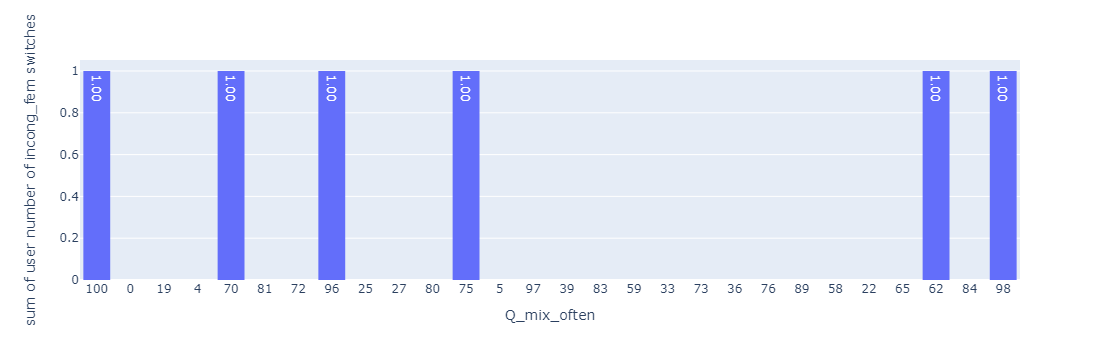

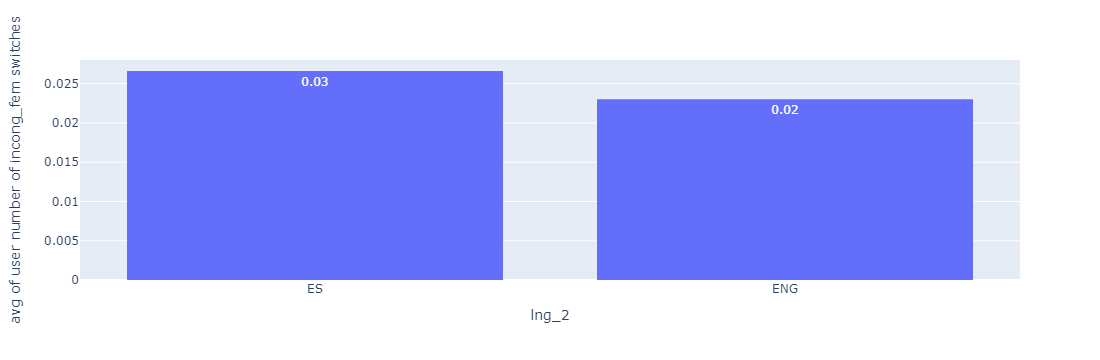

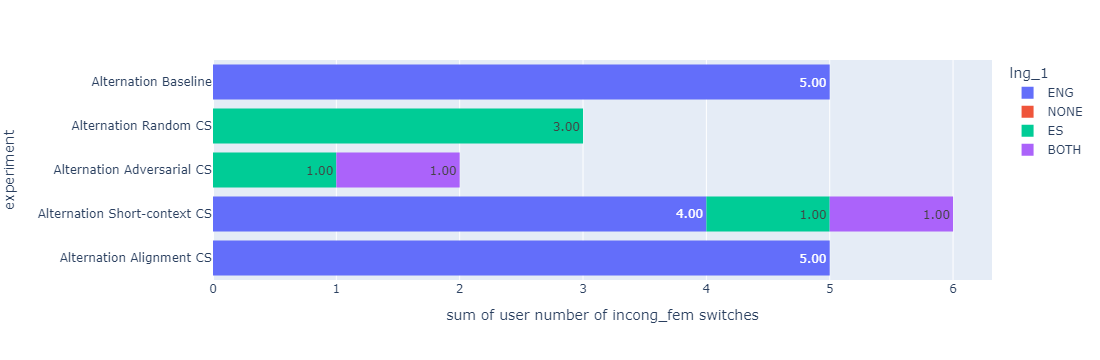

In [13]:
y = 'user number of incong_fem switches'
# y = 'user number of total ins switches'
# y = "user number of utterances with some ins switch"


px.histogram(df_copy,
             y=y,
             x='Q_mix_often',  #Q_enjoy_mix #Q_mix_often
             # color='experiment',
             text_auto='.2f',
             # histfunc='avg',
            ).show()

px.histogram(df_copy,
             y=y,
             x='lng_2',  #Q_enjoy_mix #Q_mix_often
             # color='experiment',
             text_auto='.2f',
             histfunc='avg',
            ).show()

px.histogram(df_copy,
             x=y,
             y='experiment',
             color='lng_1',
             text_auto='.2f',
             # histfunc='avg',
            ).show()

In [ ]:
df_copy.shape

In [14]:
df_copy['Enter your native language, or the language you are providing answers for, here:'].value_counts() / 4

Enter your native language, or the language you are providing answers for, here:
English                                                    92.0
Spanish                                                    50.5
english                                                    33.5
spanish                                                    14.5
English                                                     6.0
Spanish and English                                         3.0
English and Spanish                                         2.0
Spanish (native language), but communicating in English     1.0
Spanish ,English                                            1.0
english                                                     1.0
spanish and English                                         1.0
Spanish                                                     1.0
English language                                            1.0
Spanish, English                                            1.0
Español                

In [15]:
df_copy['lng_1'].value_counts()/4

lng_1
ENG     132.5
ES       66.0
BOTH      9.0
NONE      4.0
Name: count, dtype: float64

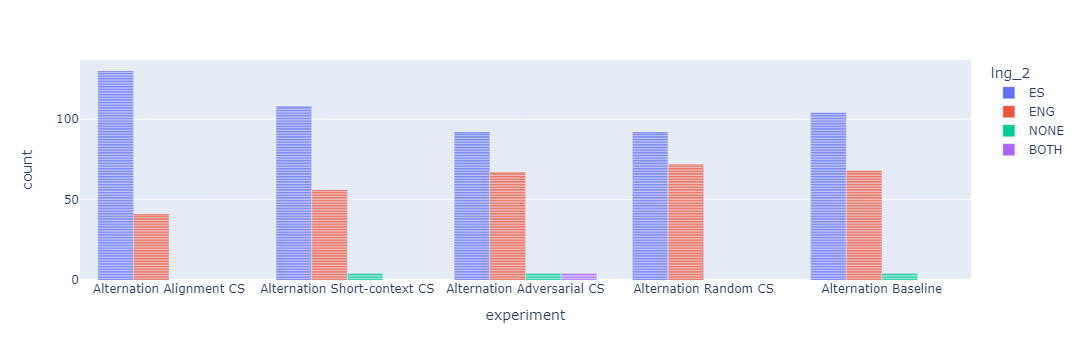

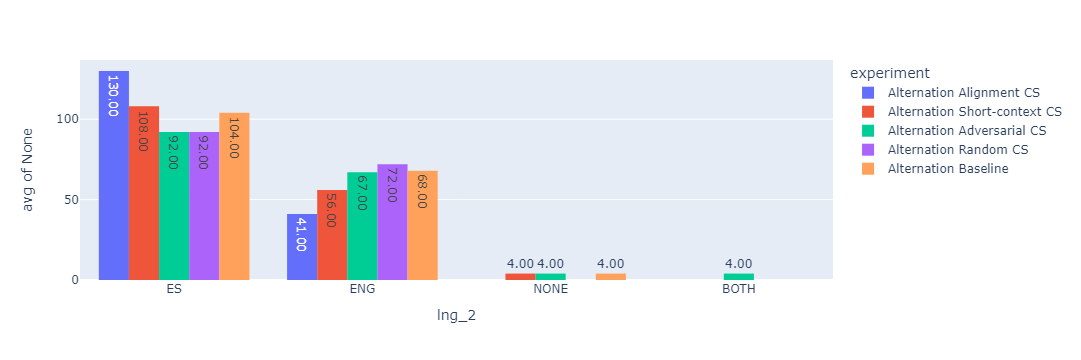

In [16]:
px.bar(df_copy,
             x='experiment',
             color='lng_2',
#                y='Q_enjoy',
               barmode="group"
            ).show()

px.histogram(df_copy,
             x='lng_2',
#              y='Q_enjoy',
             color='experiment',
             text_auto='.2f',
             histfunc='avg',
             barmode="group",
            ).show()
# px.bar(df_copy,
#              x='experiment',
#              color='lng_2',
#                barmode="group"
#             ).show()

Experiment comparison

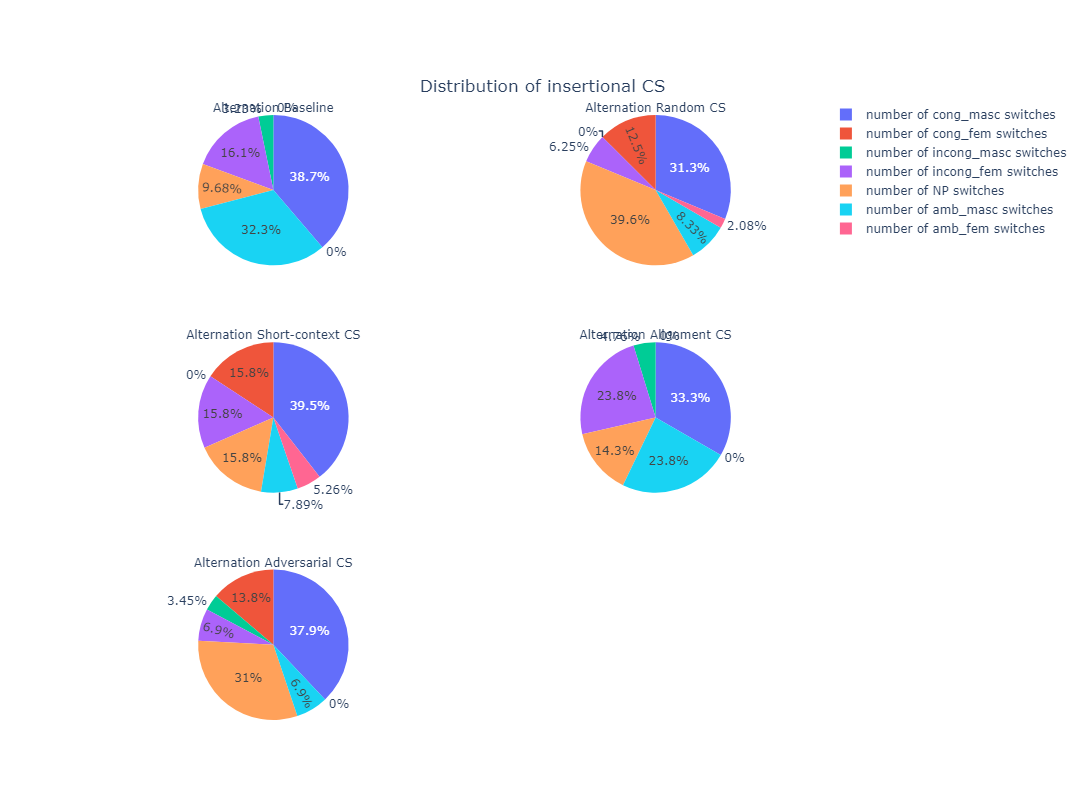

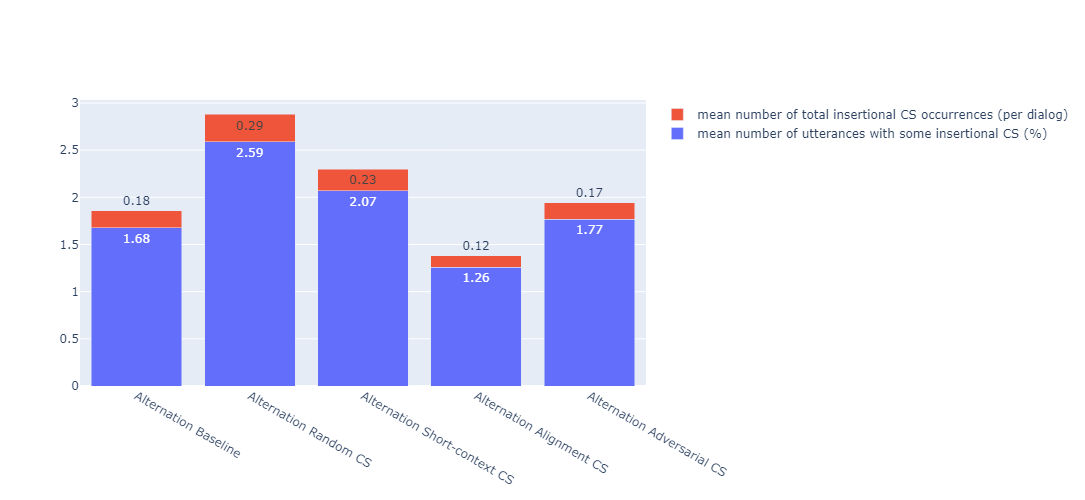

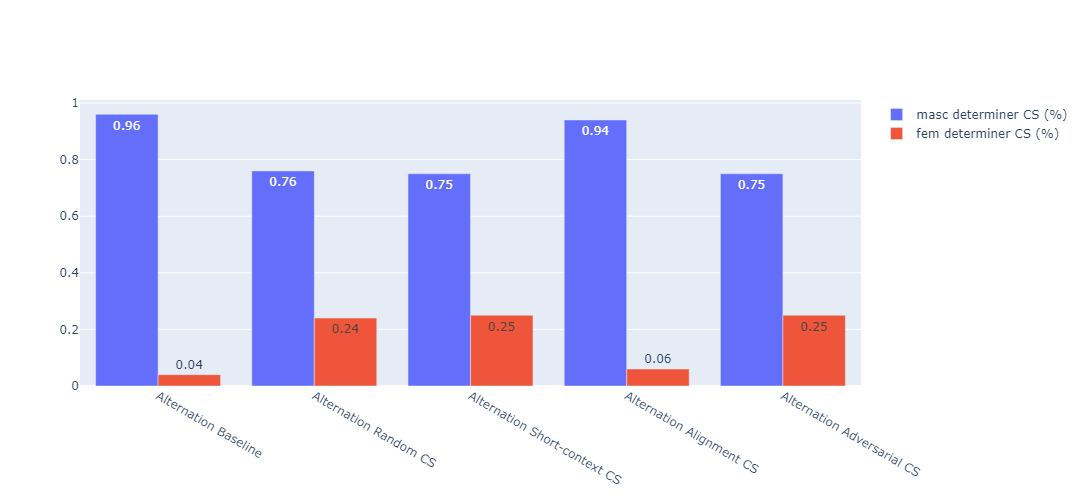

In [17]:
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math


def format_percentage(num: int) -> str:
    return round(num * 100, 2)

features=['user number of cong_masc switches',
          'user number of cong_fem switches',
          'user number of incong_masc switches', # incong 1
          'user number of incong_fem switches', # incong 2
          'user number of NP switches',
          'user number of amb_masc switches', 
          'user number of amb_fem switches']
pies=[]

mean_num_uter_w_cong_cs_normal_values = []
mean_num_of_total_cong_switch = []
masc_det = []
fem_det = []

for exp in experiments:
    exp_df = get_experiment_df([exp])
    exp_df = remove_rename_columns(exp_df)

    #bar plot
    mean_utters = np.mean(exp_df['user number of utterances'])
    mean_num_uter_w_cong_cs = np.mean(exp_df['user number of utterances with some ins switch'])
    mean_num_uter_w_cong_cs_normal_values.append(format_percentage(mean_num_uter_w_cong_cs / mean_utters))

    mean_num_of_total_cong_switch.append(round(np.mean(exp_df['user number of total ins switches']),2))

    total_det_cs = np.sum(exp_df['user number of masc det switches']) + np.sum(exp_df['user number of fem det switches'])
    
    masc_det.append(round(np.sum(exp_df['user number of masc det switches'])/total_det_cs,2))
    fem_det.append(round(np.sum(exp_df['user number of fem det switches'])/total_det_cs,2))

    # distribution of cong types
    means_ = {}
    for f in features:
        means_[f] = np.mean(exp_df[f]) / np.mean(exp_df['user number of total ins switches'])

    labels = list(means_.keys())
    labels = [l[5:] for l in labels]
    values = list(means_.values())
    pies.append(go.Pie(labels=labels,values=values, sort=False,title=exp))


rows = math.ceil(len(pies) /2)
specs = [[{"type": "domain"}, {"type": "domain"}]] * rows
opts = [(1,1), (1,2), (2,1), (2,2), (3,1)]
fig = make_subplots(
    rows=rows, cols=2,
    specs=specs,
)

for idx, p in enumerate(pies):
    row, col = opts[idx]
    fig.add_trace(p,row=row, col=col)

# fig.update_layout(height=800, width=800)
    fig.update_layout(
    width=900,
    height=800,
    title={
    'text': 'Distribution of insertional CS',
    'y':0.9,
    'x':0.5,
    'xanchor': 'center',
    'yanchor': 'top'},
)
fig.show()

fig = go.Figure()
fig.add_trace(go.Bar(x=experiments,
                    name='mean number of utterances with some insertional CS (%)',
                    y=mean_num_uter_w_cong_cs_normal_values,
                    text=mean_num_uter_w_cong_cs_normal_values))
fig.add_trace(go.Bar(x=experiments,
                    name='mean number of total insertional CS occurrences (per dialog)',
                    y=mean_num_of_total_cong_switch,
                    text=mean_num_of_total_cong_switch))
fig.update_layout(barmode='stack',width=1000,height=500)
fig.show()

fig = go.Figure()
fig.add_trace(go.Bar(x=experiments,
                    name='masc determiner CS (%)',
                    y=masc_det,
                    text=masc_det))
fig.add_trace(go.Bar(x=experiments,
                    name='fem determiner CS (%)',
                    y=fem_det,
                    text=fem_det))
fig.update_layout(width=1000,height=500)
fig.show()


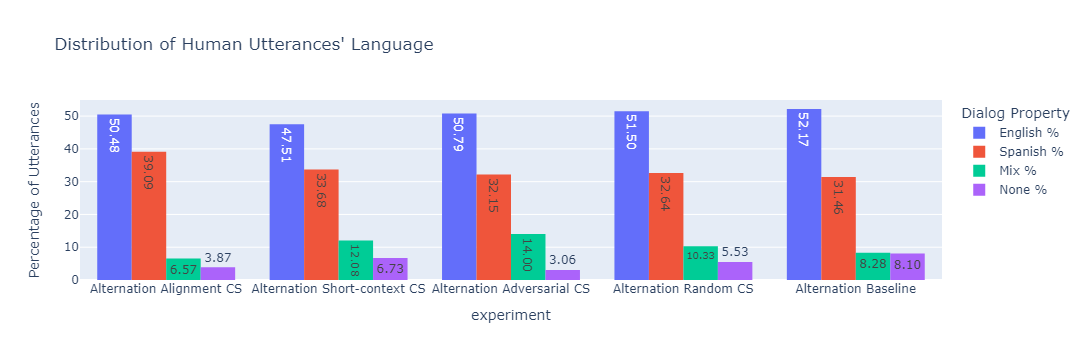

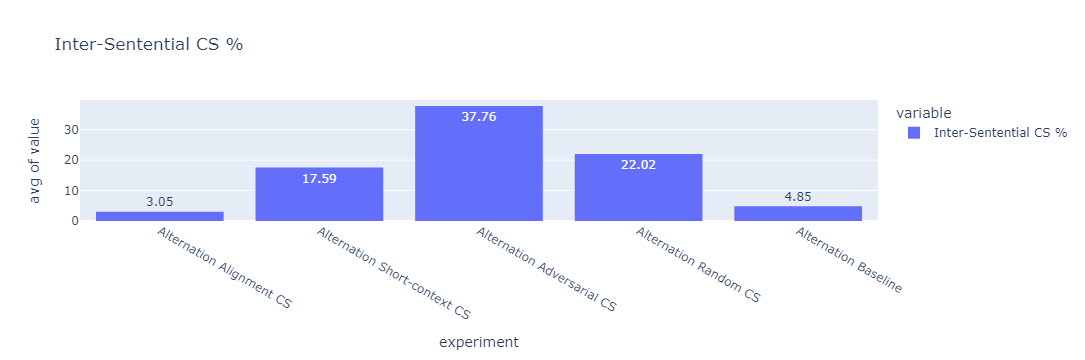

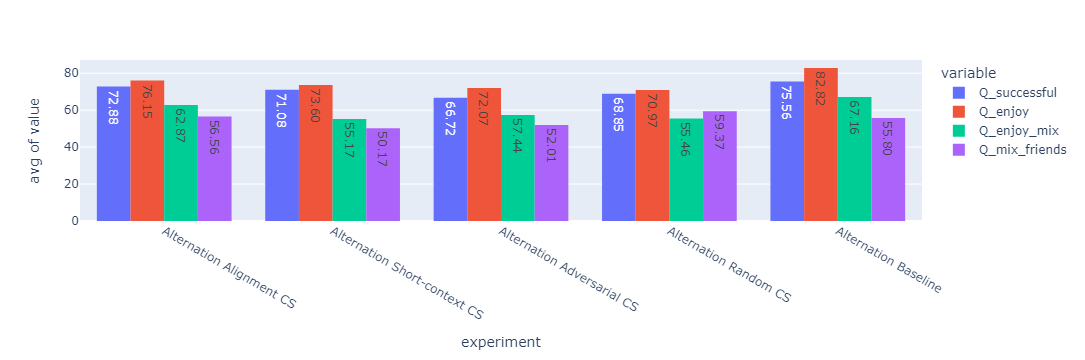

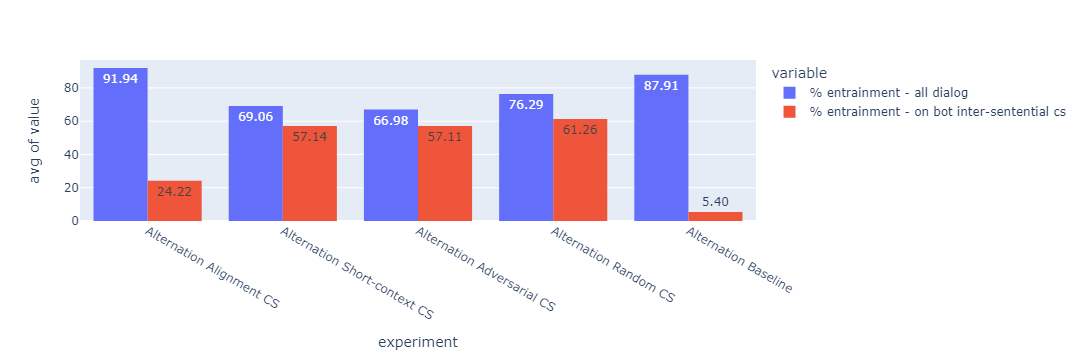

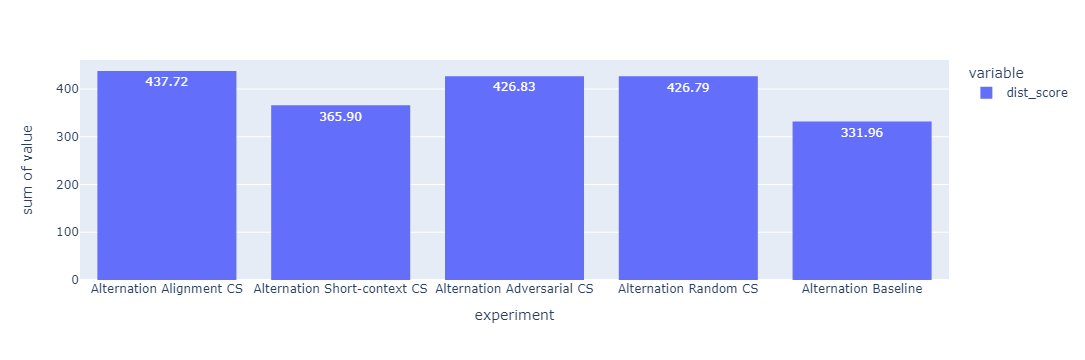

In [21]:
features=['English %', 'Spanish %', 'Mix %', 'None %'] # "Inter-Sentential CS %"]
fig = px.histogram(df_copy,
             x='experiment',
             y=features,
             text_auto='.2f',
             histfunc='avg',
             barmode="group",
             title="Distribution of Human Utterances' Language",
            )

fig.update_layout(
    yaxis_title="Percentage of Utterances",
    legend_title="Dialog Property",
)
fig.show()

features=["Inter-Sentential CS %"]
fig = px.histogram(df_copy,
             x='experiment',
             y=features,
             text_auto='.2f',
             histfunc='avg',
             barmode="group",
             title="Inter-Sentential CS %",
            )
fig.show()



if global_exp_ == 'ins':
    features=['Q_successful', 'Q_enjoy', 'Q_enjoy_mix', 'Q_mix_friends', 'Q_mix_often', 'Q_natural']
else:
    features=['Q_successful', 'Q_enjoy', 'Q_enjoy_mix', 'Q_mix_friends']
px.histogram(df_copy,
             x='experiment',
             y=features,
             text_auto='.2f',
             histfunc='avg',
             barmode="group",
            ).show()


px.histogram(df_copy,
             x='experiment',
             y=['% entrainment - all dialog','% entrainment - on bot inter-sentential cs'],
             text_auto='.2f',
             histfunc='avg',
             barmode="group",
            ).show()

features=['dist_score']  #is_time_success #'game_time']
px.histogram(df_copy,
             x='experiment',
             y=features,
             text_auto='.2f',
             # histfunc='avg',
             barmode="group",
            ).show()